iris dataset has 150 data points, each data point has 4 features 
(150, 2)


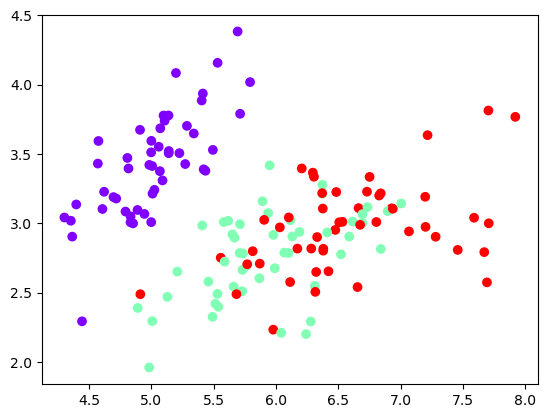

In [6]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import neighbors, datasets
from sklearn.metrics import pairwise_distances
from sklearn.utils import shuffle

# import some data to play with
iris = datasets.load_iris()
print(f'iris dataset has {iris.data.shape[0]} data points, each data point has {iris.data.shape[1]} features ')
X = iris.data[:, :2]   # we only take the first two features
X = X + 0.03 * np.random.RandomState(10).randn(*X.shape) # Add random noise since iris has exact values
y = iris.target
X, y = shuffle(X, y, random_state=10)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
print(X.shape)

In [7]:
class SimpleKNNClassifier():
    def __init__(self, X_train, y_train, k=1):
        self.X_train = X_train
        self.y_train = y_train
        self.k = k
        
    def predict(self, X):
        # 1. Compute distances 
        D = np.nan * np.ones((X.shape[0], self.X_train.shape[0]))
        for i, x in enumerate(X):
            for j, xt in enumerate(self.X_train):
                D[i, j] = np.linalg.norm(x-xt)
        # Much faster vectorized version using sklearn's pairwise distances function
        D2 = pairwise_distances(X, self.X_train, metric='euclidean')
        assert np.allclose(D, D2), 'Should be the same'
        
        # 2. Get the indices of the top k smallest distances
        sorted_idx = np.argsort(D, axis=1)
        
        # For each data point get mode
        y = np.array([
            scipy.stats.mode(self.y_train[sidx[:self.k]],keepdims=True)[0][0]
            for sidx in sorted_idx
        ])
        # Faster vectorized version
        y_ind = self.y_train[sorted_idx[:,:self.k]]
        y2 = scipy.stats.mode(y_ind, axis=1,keepdims=True)[0].ravel()
        assert np.all(y == y2), 'Should be the same'
        return y


In [9]:
k = 1 #3 or 10
knn = SimpleKNNClassifier(X, y, k=k)
y_pred = knn.predict(X)
accuracy = np.mean(y == y_pred)
print(f'The accuracy on the training data for k={k} is: {accuracy*100:.1f}%')

The accuracy on the training data for k=1 is: 100.0%


## Do we really think our method has PERFECT accuracy?

## Suppose we only had 100 points for training and then received 50 new flower measurments

In [10]:
# Use first 100 points
X_train = X[:100,:]
y_train = y[:100]
X_test = X[100:,:]
y_test = y[100:]

# Setup model
for k in [1, 3, 5, 7, 9]:
    knn = SimpleKNNClassifier(X_train, y_train, k=k)

    # Predict on training data
    y_pred = knn.predict(X_train)
    accuracy = np.mean(y_train == y_pred)
    print(f'The accuracy on the training data for k={k} is: {accuracy*100:.1f}%')

    # Now let's test our method on the new flowers
    y_pred = knn.predict(X_test)
    accuracy = np.mean(y_test == y_pred)
    print(f'The accuracy on the test data for k={k} is: {accuracy*100:.1f}%\n')

The accuracy on the training data for k=1 is: 100.0%
The accuracy on the test data for k=1 is: 64.0%

The accuracy on the training data for k=3 is: 90.0%
The accuracy on the test data for k=3 is: 66.0%

The accuracy on the training data for k=5 is: 88.0%
The accuracy on the test data for k=5 is: 72.0%

The accuracy on the training data for k=7 is: 87.0%
The accuracy on the test data for k=7 is: 74.0%

The accuracy on the training data for k=9 is: 87.0%
The accuracy on the test data for k=9 is: 74.0%



# The above generalization accuracy estimation algorithm is known as using a train/test split

# Cross validation 

In [11]:
def cv_estimate(X, k, n_splits=3):
    # Setup split indices
    split_ind = np.floor(np.linspace(0, X.shape[0], num=n_splits+1))
    # Loop over splits
    accuracy_list = []
    for split_start, split_end in zip(split_ind[:-1], split_ind[1:]):
        # Setup boolean array to select test set
        test = np.zeros(X.shape[0], dtype=bool)  # Initialize false boolean array
        test[int(split_start):int(split_end)] = True  # Set test elements to true
        
        # Create train and test sets
        X_train = X[~test, :] # ~ is used to denote "not" for all boolean values
        y_train = y[~test]
        X_test = X[test, :]
        y_test = y[test]
        
        # Train model for this split using X_train and y_train
        knn = SimpleKNNClassifier(X_train, y_train, k=k)
        
        # Compute accuracy on test split
        y_pred = knn.predict(X_test)
        accuracy = np.mean(y_test == y_pred)
        accuracy_list.append(accuracy)
    # Take mean of accuracy
    return np.mean(accuracy_list)

for k in [1, 3, 5, 7, 9]:
    # n_splits is often 3, 5, 10; X.shape[0] (i.e., one split per sample) is known as Leave One Out (LOO)
    cv_acc = cv_estimate(X, k, n_splits=3) 
    print(f'CV accuracy estimate for k={k} is {100*cv_acc:.1f}%')

CV accuracy estimate for k=1 is 70.7%
CV accuracy estimate for k=3 is 70.0%
CV accuracy estimate for k=5 is 70.7%
CV accuracy estimate for k=7 is 72.7%
CV accuracy estimate for k=9 is 73.3%
